https://github.com/slim1017/VaDE

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as nn_utils
from sklearn import mixture, cluster
import numpy as np
import math
import sys
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt

In [16]:
###############################################################################
#                                VaDE CLASS                                   #
###############################################################################
class VaDE(nn.Module):
    def __init__(self, original_dim, hidden_dims, latent_dim, n_clusters, data_type='sigmoid'):
        super(VaDE, self).__init__()
        self.original_dim = original_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.n_clusters = n_clusters
        self.data_type = data_type

        # --------------------- Encoder ---------------------
        encoder_layers = []
        input_dim = original_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(input_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            input_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mean = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_log_var = nn.Linear(hidden_dims[-1], latent_dim)

        # --------------------- Decoder ---------------------
        decoder_layers = []
        input_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(input_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            input_dim = h_dim
        self.decoder = nn.Sequential(*decoder_layers)
        self.fc_output = nn.Linear(hidden_dims[0], original_dim)
        
        # --------------------- GMM parameters ---------------------
        # Raw mixture weights initialized to uniform
        self.raw_pi = nn.Parameter(torch.log(torch.ones(n_clusters) / n_clusters))
        # Means [n_clusters, latent_dim]
        self.mu = nn.Parameter(torch.zeros(n_clusters, latent_dim))
        # Log-variances [n_clusters, latent_dim]
        self.log_var_gmm = nn.Parameter(torch.zeros(n_clusters, latent_dim))

    def encode(self, x):
        h = self.encoder(x)
        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def decode(self, z):
        h = self.decoder(z)
        x_recon = self.fc_output(h)
        if self.data_type == 'sigmoid':
            # For data in [0,1], but this can be changed to 'linear' if needed
            x_recon = torch.sigmoid(x_recon)
        elif self.data_type == 'linear':
            pass
        else:
            raise ValueError('Unsupported data_type')
        return x_recon

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_recon = self.decode(z)
        return x_recon, z_mean, z_log_var, z

    def get_pi(self):
        return F.softmax(self.raw_pi, dim=0)

In [17]:
###############################################################################
#                             LOSS FUNCTION                                   #
###############################################################################
def loss_function(model, x, x_recon, z_mean, z_log_var, alpha):
    # Clamp log variance to prevent numerical issues
    z_log_var = torch.clamp(z_log_var, min=-10, max=10)
    
    # --------------------- Reconstruction loss ---------------------
    if model.data_type == 'sigmoid':
        # BCE for data in [0,1]. Note that we do NOT automatically scale by dimension
        recon_loss = alpha * F.binary_cross_entropy(x_recon, x, reduction='sum')
    else:
        # MSE for more general data
        recon_loss = alpha * F.mse_loss(x_recon, x, reduction='sum')
    
    # --------------------- KL Divergence ---------------------
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    
    # --------------------- GMM Loss ---------------------
    pi = model.get_pi().unsqueeze(0)  # shape: [1, n_clusters]
    mu = model.mu.unsqueeze(0)        # shape: [1, n_clusters, latent_dim]
    var = torch.exp(model.log_var_gmm).unsqueeze(0)  # shape: [1, n_clusters, latent_dim]
    var = torch.clamp(var, min=1e-6, max=1e6)

    z = z_mean.unsqueeze(1)  # shape: [batch_size, 1, latent_dim]

    # log_p_z
    log_p_z = -0.5 * torch.sum(
        torch.log(2 * math.pi * var) + ((z - mu) ** 2) / var,
        dim=2
    )
    log_p_z = log_p_z + torch.log(pi + 1e-10)

    # log_q_z
    log_q_z = -0.5 * torch.sum(
        z_log_var.unsqueeze(1) + ((z_mean.unsqueeze(1) - mu) ** 2) / var,
        dim=2
    )

    # gamma
    gamma = F.softmax(log_p_z, dim=1)

    # entropy of gamma
    entropy = -torch.sum(gamma * torch.log(gamma + 1e-10), dim=1)

    # GMM loss
    gmm_loss_per_sample = torch.sum(gamma * (log_p_z - log_q_z), dim=1) - entropy
    gmm_loss = torch.sum(gmm_loss_per_sample)

    return recon_loss, kl_loss, gmm_loss, recon_loss + kl_loss + gmm_loss


In [18]:
###############################################################################
#                          PRETRAINING THE AE                                 #
###############################################################################
def pretrain_ae(model, data_loader, optimizer, epochs, device):
    model.train()
    for epoch_num in range(1, epochs + 1):
        total_loss = 0
        for batch_idx, (data,) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            x_recon, _, _, _ = model(data)
            
            if model.data_type == 'sigmoid':
                loss = F.binary_cross_entropy(x_recon, data, reduction='sum')
            else:
                loss = F.mse_loss(x_recon, data, reduction='sum')
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(data_loader.dataset)
        print(f'Pretrain Epoch [{epoch_num}/{epochs}], Loss: {avg_loss:.4f}')



In [19]:
###############################################################################
#                       GET LATENT MEANS FROM MODEL                           #
###############################################################################
def get_z_mean(model, data_loader, device):
    model.eval()
    z_mean_all = []
    with torch.no_grad():
        for batch_idx, (data,) in enumerate(data_loader):
            data = data.to(device)
            z_mean, z_log_var = model.encode(data)
            z_mean_all.append(z_mean.cpu().numpy())
    z_mean_all = np.concatenate(z_mean_all, axis=0)
    return z_mean_all



In [20]:
###############################################################################
#        INITIALIZE GMM PARAMETERS (kmeans or GMM, as per original code)      #
###############################################################################
def initialize_gmm_parameters(model, z_mean_all, dataset_tag):
    # You can choose to initialize with either GMM or KMeans, depending on your needs
    # Here we show an example with GMM for arbitrary dataset:
    gmm = mixture.GaussianMixture(n_components=model.n_clusters, covariance_type='diag', random_state=42)
    gmm.fit(z_mean_all)
    model.mu.data = torch.tensor(gmm.means_, dtype=torch.float32).to(model.mu.device)
    model.log_var_gmm.data = torch.tensor(np.log(gmm.covariances_ + 1e-6), dtype=torch.float32).to(model.log_var_gmm.device)
    model.log_var_gmm.data = torch.clamp(model.log_var_gmm.data, min=-10, max=10)
    model.raw_pi.data = torch.log(torch.tensor(gmm.weights_, dtype=torch.float32) + 1e-10)

    pi = F.softmax(model.raw_pi, dim=0)
    assert torch.isclose(pi.sum(), torch.tensor(1.0, device=model.raw_pi.device), atol=1e-4), "Mixing coefficients do not sum to 1."
    assert torch.all(pi > 0), "Mixing coefficients contain non-positive values."


In [21]:
###############################################################################
#                        CLUSTER ACCURACY FUNCTION                            #
###############################################################################
def cluster_acc(y_true, y_pred):
    """
    Hungarian-based cluster accuracy.
    """
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)

    assert y_pred.size == y_true.size, "The size of y_pred and y_true must be equal."

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    total_correct = sum([w[i, j] for i, j in zip(row_ind, col_ind)])

    return total_correct / y_pred.size


In [22]:
###############################################################################
#                             TRAINING FUNCTION                               #
###############################################################################
def train_vade(model, data, Y, config, device):
    # -------------------- Unpack config --------------------
    batch_size = config['batch_size']
    epochs = config['epochs']
    pretrain_epochs = config['pretrain_epochs']
    lr_nn = config['lr_nn']
    lr_gmm = config['lr_gmm']
    decay_n = config['decay_n']
    decay_nn = config['decay_nn']
    decay_gmm = config['decay_gmm']
    alpha = config['alpha']
    pretrain = config['pretrain']
    dataset_tag = config['dataset_tag']  # custom string for logs if needed
    
    # -------------------- Prepare data loader --------------------
    dataset_tensor = torch.tensor(data, dtype=torch.float32)
    tensor_dataset = TensorDataset(dataset_tensor)
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # -------------------- Define separate optimizers --------------------
    # Autoencoder parameters
    autoencoder_parameters = (
        list(model.encoder.parameters()) +
        list(model.fc_mean.parameters()) +
        list(model.fc_log_var.parameters()) +
        list(model.decoder.parameters()) +
        list(model.fc_output.parameters())
    )
    optimizer_ae = torch.optim.Adam(autoencoder_parameters, lr=lr_nn, weight_decay=1e-5)
    scheduler_ae = torch.optim.lr_scheduler.StepLR(optimizer_ae, step_size=decay_n, gamma=decay_nn)

    # GMM parameters
    optimizer_gmm = torch.optim.Adam([model.raw_pi, model.mu, model.log_var_gmm],
                                     lr=lr_gmm, weight_decay=1e-5)
    scheduler_gmm = torch.optim.lr_scheduler.StepLR(optimizer_gmm, step_size=decay_n, gamma=decay_gmm)

    # -------------------- Pretraining --------------------
    if pretrain:
        print("Starting pretraining of the autoencoder...")
        pretrain_ae(model, data_loader, optimizer_ae, pretrain_epochs, device)

    # -------------------- Initialize GMM parameters --------------------
    if pretrain:
        print("Initializing GMM parameters based on the pretrained encoder...")
        z_mean_all = get_z_mean(model, data_loader, device)
        initialize_gmm_parameters(model, z_mean_all, dataset_tag)
        print("GMM parameters initialized.")

    # -------------------- Initialize Loss History --------------------
    total_loss_history = []
    recon_loss_history = []
    kl_loss_history = []
    gmm_loss_history = []

    # -------------------- Main training --------------------
    model.train()
    for epoch in range(1, epochs + 1):
        epoch_total_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_kl_loss = 0.0
        epoch_gmm_loss = 0.0

        for batch_idx, (x_batch,) in enumerate(data_loader):
            x_batch = x_batch.to(device)
            optimizer_ae.zero_grad()
            optimizer_gmm.zero_grad()

            x_recon, z_mean, z_log_var, _ = model(x_batch)

            # Compute the full VaDE loss
            recon_loss, kl_loss, gmm_loss, total_loss = loss_function(model, x_batch, x_recon, z_mean, z_log_var, alpha)
            total_loss.backward()

            # Gradient clipping
            nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer_ae.step()
            optimizer_gmm.step()

            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            epoch_gmm_loss += gmm_loss.item()

        avg_total_loss = epoch_total_loss / len(data_loader.dataset)
        avg_recon_loss = epoch_recon_loss / len(data_loader.dataset)
        avg_kl_loss = epoch_kl_loss / len(data_loader.dataset)
        avg_gmm_loss = epoch_gmm_loss / len(data_loader.dataset)

        # Store losses
        total_loss_history.append(avg_total_loss)
        recon_loss_history.append(avg_recon_loss)
        kl_loss_history.append(avg_kl_loss)
        gmm_loss_history.append(avg_gmm_loss)

        print(f'Epoch {epoch}, Loss: {avg_total_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, GMM Loss: {avg_gmm_loss:.4f}')

        # Step the schedulers
        scheduler_ae.step()
        scheduler_gmm.step()

        # Optional: Evaluate clustering accuracy every N epochs
        if epoch % 10 == 0 or epoch == 1:
            model.eval()
            with torch.no_grad():
                z_mean_all = get_z_mean(model, data_loader, device)
                
                if config['clustering_method'] == 'gmm':
                    # Fit GMM on new latent space
                    gmm = mixture.GaussianMixture(n_components=model.n_clusters, covariance_type='diag', random_state=42)
                    gmm.fit(z_mean_all)
                    y_pred = gmm.predict(z_mean_all)
                elif config['clustering_method'] == 'kmeans':
                    # Apply KMeans clustering on latent space
                    kmeans = KMeans(n_clusters=model.n_clusters, random_state=42)
                    kmeans.fit(z_mean_all)
                    y_pred = kmeans.labels_
                else:
                    raise ValueError("Unsupported clustering method. Choose 'gmm' or 'kmeans'")
                
                acc = cluster_acc(Y, y_pred)
                ari = adjusted_rand_score(Y, y_pred)
                print(f'Clustering Accuracy: {acc * 100:.2f}%, Adjusted Rand Index: {ari:.4f}')
            model.train()

    return total_loss_history, recon_loss_history, kl_loss_history, gmm_loss_history


In [23]:
def plot_train(total_loss_history, recon_loss_history, kl_loss_history, gmm_loss_history,
               epochs):
        # -------------------- Plot Training Loss --------------------
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, epochs + 1), total_loss_history, color='blue', label='Total Loss')
    plt.plot(range(1, epochs + 1), recon_loss_history, color='green', label='Reconstruction Loss')
    plt.plot(range(1, epochs + 1), kl_loss_history, color='red', label='KL Loss')
    plt.plot(range(1, epochs + 1), gmm_loss_history, color='orange', label='GMM Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Components over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
###############################################################################
#                                MAIN SCRIPT                                  #
###############################################################################


In [25]:
df_meta_data = pd.read_csv('../data/simulated/metadata.csv', sep=",")
df_meta_data = df_meta_data.rename(columns={
    'sample_id': 'file',
    # 'class': 'condition'
    'subclass': 'condition'  
})

# Optional: obtain integer labels from condition column
# E.g., condition_A -> 0, condition_B -> 1, etc.
unique_conditions = df_meta_data['condition'].unique()
condition_to_id = {c: i for i, c in enumerate(unique_conditions)}
Y = df_meta_data['condition'].map(condition_to_id).values  # shape [n_samples]

# ------------------ (B) LOAD & STANDARDIZE PROTEOMICS DATA ---------------
df = pd.read_csv('../data/simulated/simulated_data.csv', sep=",")
# Align the columns: ensure the order matches the metadata's sample order
df = df.loc[:, df_meta_data['file'].values]
# data is [n_samples x n_features] after transpose
data = df.T.values

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [26]:
# --------------------- Define config for your data -----------------------
# Make sure 'original_dim' matches number of columns in data (i.e. n_features).
# 'n_clusters' can match the number of unique conditions in your data, or set as you need.
config = {
    'original_dim': data_scaled.shape[1], 
    'hidden_dims': [500, 500, 2000],  # example architecture
    'latent_dim': 10,
    'n_clusters': len(unique_conditions),  # or set manually
    'lr_nn': 0.0001,
    'lr_gmm': 0.0001,
    'decay_n': 10,
    'decay_nn': 0.9,
    'decay_gmm': 0.9,
    'epochs': 3,
    'pretrain_epochs': 3,
    'batch_size': 64,
    'alpha': 1.0,
    'pretrain': True,
    'dataset_tag': 'mySimData',  # custom identifier
    # Choose 'sigmoid' or 'linear' depending on your data range
    'data_type': 'linear',
    'clustering_method': 'kmeans'  # options: 'gmm' or 'kmeans'
}


In [27]:
# ------------------------ DEVICE CONFIG ----------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ------------------------ MODEL INIT -------------------------------------
model = VaDE(
    original_dim=config['original_dim'],
    hidden_dims=config['hidden_dims'],
    latent_dim=config['latent_dim'],
    n_clusters=config['n_clusters'],
    data_type=config['data_type']
).to(device)


Using device: cpu


In [28]:
# ------------------------ TRAIN MODEL ------------------------------------
total_loss_history, recon_loss_history, kl_loss_history, gmm_loss_history = \
    train_vade(model, data_scaled, Y, config, device)


Starting pretraining of the autoencoder...
Pretrain Epoch [1/3], Loss: 6994.2220
Pretrain Epoch [2/3], Loss: 6527.2326
Pretrain Epoch [3/3], Loss: 6069.2932
Initializing GMM parameters based on the pretrained encoder...
GMM parameters initialized.
Epoch 1, Loss: 6160.4656, Recon Loss: 6041.9785, KL Loss: 145.1487, GMM Loss: -26.6616
Clustering Accuracy: 21.00%, Adjusted Rand Index: -0.0021
Epoch 2, Loss: 6173.7748, Recon Loss: 6057.7455, KL Loss: 142.7351, GMM Loss: -26.7058
Epoch 3, Loss: 6174.2618, Recon Loss: 6058.4470, KL Loss: 142.5318, GMM Loss: -26.7169


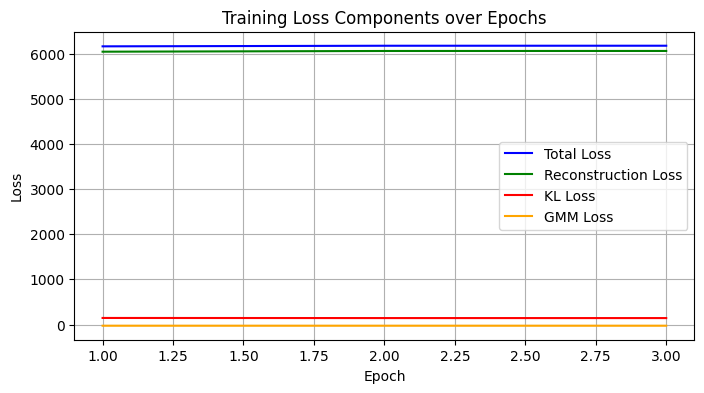

In [29]:
plot_train(total_loss_history, recon_loss_history, kl_loss_history, gmm_loss_history,
           config['epochs']
    )

In [30]:
# ------------------------ FINAL EVALUATION -------------------------------
model.eval()
with torch.no_grad():
    z_mean_all = []
    dataset_final = TensorDataset(torch.tensor(data_scaled, dtype=torch.float32))
    loader_final = DataLoader(dataset_final, batch_size=config['batch_size'], shuffle=False)
    for (x_batch,) in loader_final:
        x_batch = x_batch.to(device)
        _, z_mean, _, _ = model(x_batch)
        z_mean_all.append(z_mean.cpu().numpy())
    z_mean_all = np.concatenate(z_mean_all, axis=0)

    # Fit clustering algorithm on entire latent space (final)
    if config['clustering_method'] == 'gmm':
        gmm = mixture.GaussianMixture(
            n_components=config['n_clusters'], 
            covariance_type='diag', 
            random_state=42
        )
        gmm.fit(z_mean_all)
        y_pred = gmm.predict(z_mean_all)
    elif config['clustering_method'] == 'kmeans':
        kmeans = KMeans(n_clusters=config['n_clusters'], random_state=42)
        kmeans.fit(z_mean_all)
        y_pred = kmeans.labels_
    else:
        raise ValueError("Unsupported clustering method. Choose 'gmm' or 'kmeans'")

    # Compute final clustering metrics
    acc = cluster_acc(Y, y_pred)
    ari = adjusted_rand_score(Y, y_pred)
    print(f'Final Clustering Accuracy: {acc * 100:.2f}%')
    print(f'Final Adjusted Rand Index: {ari:.4f}')

Final Clustering Accuracy: 98.75%
Final Adjusted Rand Index: 0.9774


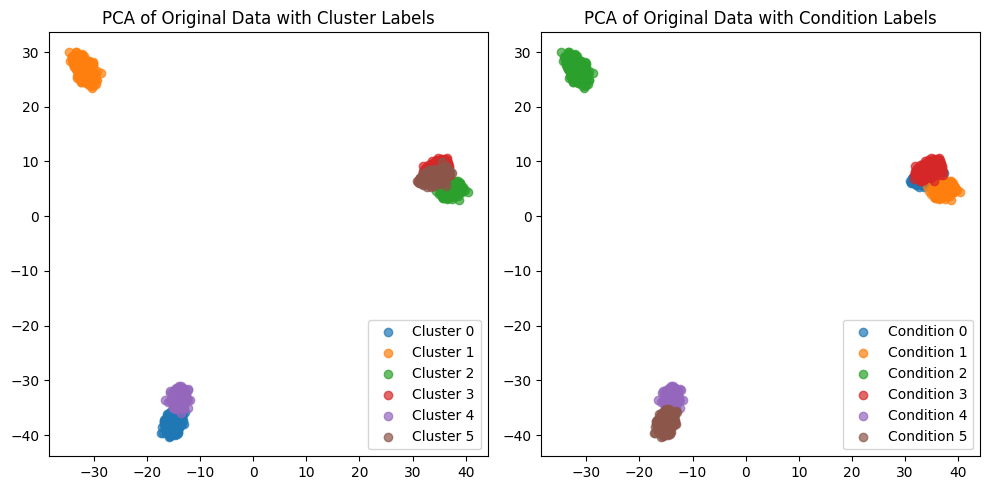

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA Visualization
pca = PCA(n_components=2, random_state=42)
latent_2d = pca.fit_transform(df.T)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot with Cluster Labels
for cluster in np.unique(y_pred):
    indices = (y_pred == cluster)
    axes[0].scatter(
        latent_2d[indices, 0], 
        latent_2d[indices, 1], 
        label=f'Cluster {cluster}',
        alpha=0.7)
    
    indices = (Y == cluster)
    axes[1].scatter(
        latent_2d[indices, 0],
        latent_2d[indices, 1],
        label=f'Condition {cluster}',
        alpha=0.7
    )

axes[0].set_title('PCA of Original Data with Cluster Labels')
axes[0].legend()    
axes[1].set_title('PCA of Original Data with Condition Labels')
axes[1].legend()

plt.tight_layout()
plt.show()


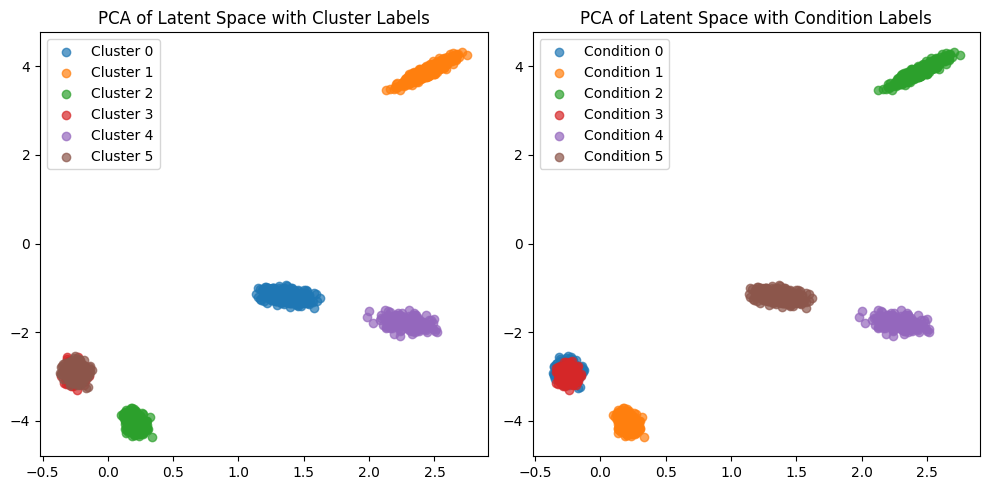

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA Visualization on Latent Space
# pca = PCA(n_components=2, random_state=42)
# latent_2d = pca.fit_transform(z_mean_all)

latent_2d = z_mean_all.copy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot with Cluster Labels
for cluster in np.unique(y_pred):
    indices = (y_pred == cluster)
    axes[0].scatter(
        latent_2d[indices, 0], 
        latent_2d[indices, 1], 
        label=f'Cluster {cluster}',
        alpha=0.7)
    
    indices = (Y == cluster)
    axes[1].scatter(
        latent_2d[indices, 0],
        latent_2d[indices, 1],
        label=f'Condition {cluster}',
        alpha=0.7
    )

axes[0].set_title('PCA of Latent Space with Cluster Labels')
axes[0].legend()    
axes[1].set_title('PCA of Latent Space with Condition Labels')
axes[1].legend()

plt.tight_layout()
plt.show()
